In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Task a) Generating Dataset

In [2]:
n = 200
Xi = np.random.rand(n)
Nd = np.random.normal(0, 1, n)
Yi = []
for i, e in enumerate(Nd):
    #Yi.append(np.sin(2*np.pi*Xi[i]/float(n/2)) + e)
    Yi.append(np.sin(Xi[i]) + e)

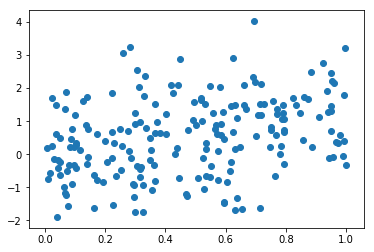

In [3]:
plt.scatter(Xi,Yi)

In [4]:
def kernel_poly(X, degree):
    if degree>=2:
        for i in range(2, degree+1):
            X = np.append(X, X[:,1:]**i, axis=1)
    return np.matrix(X)

def kernel_radial(X, lmda):
    means = []
    X_Sig = X[:,0,None]
    for i in range(1, X.shape[1]):
        means.append(np.mean(X[:,i]))
    for i in range(1, X.shape[1]):
        for ui in means:
            rad = np.exp( (1/lmda) * (X[:,i,None] - ui)**2)
            X_Sig = np.append(X_Sig, rad, axis=1)
    return np.matrix(X_Sig)

#compute coefficent-vector b
def train(X, Y, delta, I):
    return np.linalg.inv(X.transpose()*X +(delta**2)*I)*X.transpose()*Y
    
#compute modeled Y
def test(x, b):
    return x*b

#compute quadric loss
def calcLoss(testY, predY):
    #dist = (Y-Y_r)
    loss = 0
    dist = []
    for i,v in enumerate(testY.tolist()[0]):
        dist.append((testY.item(i)-predY.item(i))**2)
    for i,v in enumerate(dist):
        loss += dist[i]
    return (loss/len(dist))
    
def ridge_regress(trainX, trainY, testX, testY, delta = 0, mode = 'poly', degree = 1, lmbda = 1):
    #Preprocess to convert for Matrix-Operations
    #X = np.matrix(X)
    trainY = np.matrix(trainY).transpose()
    testY = np.matrix(testY).transpose()
    #Transform X with Kernel-Function
    if mode is 'poly':
        trainX = kernel_poly(trainX, degree)
        testX = kernel_poly(testX, degree)
    elif mode is 'radial':
        trainX = kernel_radial(trainX, lmbda)
        testX = kernel_radial(testX, lmbda)
    #Prepare sym. Matrix for penalty-term
    I = np.ones(trainX.shape[1])
    I = np.diag(I)
    #compute coefficent-vector b
    b = train(trainX, trainY, delta, I)
    #compute modeled Y
    predY = test(testX, b)
    #compute quadric loss
    loss = calcLoss(testY, predY)
    return b, loss, predY

In [5]:
#simple linear regression example
Y = np.array(Yi)
x = np.array(Xi)
padding = np.ones(len(x))
X = np.stack((padding, x), axis=1)
trainX = X
testX = X
trainY = Y
testY =Y
b, loss, Yp = ridge_regress(trainX, trainY, testX, testY, delta = 1, degree = 1)
loss

0.0006823939685705306

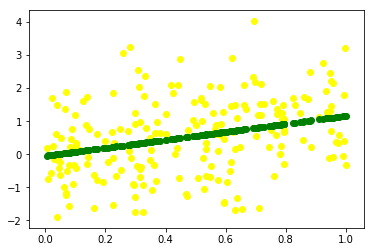

In [6]:
plt.scatter(x,  Y, color='yellow')
plt.scatter(x, Yp.tolist(), color='green')
plt.plot()
plt.show()
plt.close()

## Task b) Validate and Visualize Polynomial Regression

In [7]:
#polynomial regression example
Y = np.array(Yi)
x = np.array(Xi)
padding = np.ones(len(x))
X = np.stack((padding, x), axis=1)
trainX = X
testX = X
trainY = Y
testY =Y
b, loss, Yp = ridge_regress(trainX, trainY, testX, testY, delta=1, degree = 5)
loss

0.005311300857210645

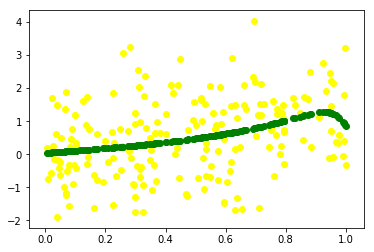

In [8]:
plt.scatter(x,  Y, color='yellow')
plt.scatter(x, Yp.tolist(), color='green')
plt.plot()
plt.show()
plt.close()

In [9]:
#5-fold Cross-Validation
import random

def crossvalidation(X, Y, maxParam, mode, k=5):
    X,Y = shuffleList(X,Y)
    lx = splitKFolds(X, k)
    ly = splitKFolds(Y, k)
    lossAll = []
    paramAll = []
    for i in range(1, maxParam):
        loss = calcLossPerParamValue(lx, ly, i, mode)
        lossAll.append(loss)
        paramAll.append(i)
    return paramAll, lossAll
    
def shuffleList(X,Y):
    zipped = list(zip(X,Y))
    random.shuffle(zipped)
    x, y = zip(*zipped)
    X=[]
    X.append(x)
    X= [x for a in X for x in a]
    Y=[]
    Y.append(y)
    Y= [y for a in Y for y in a]
    return X, Y
    
def calcLossPerParamValue(lx, ly, paramValue, mode):
    lossAverage = 0.0
    for i in range(len(lx)):
        trainX, testX = splitTrainTest(lx, i)
        trainY, testY = splitTrainTest(ly, i)
        if mode == "poly":
            b, loss, Yp = ridge_regress(trainX, trainY, testX, testY, delta=1, mode="poly", degree=paramValue)
        else:
            b, loss, Yp = ridge_regress(trainX, trainY, testX, testY, delta=1, mode="radial", lmbda=paramValue)
        lossAverage = lossAverage + loss
    return lossAverage / len(lx)

def splitTrainTest(l, i):
    test = l[i]
    train = []
    for j in range(len(l)):
        if j != i:
            train = train + l[j]
    return np.array(train), np.array(test)
    
def splitKFolds(X, k):
    step = int((len(X) - (len(X) % k)) / k)
    l = []
    for i in range(0, len(X) - (len(X) % k), step):
        l.append(X[i:i + step])
    if (len(X) % k) > 0:
        for i in X[-(len(X) % k):]:
            l[-1].append(i) 
    return l

In [10]:
#polynomial regression example
Y = np.array(Yi)
x = np.array(Xi)
padding = np.ones(len(x))
X = np.stack((padding, x), axis=1)
degree, loss = crossvalidation(X.tolist(), Y.tolist(), 13, "poly")
loss

[0.7381125232780905,
 0.7645101523576745,
 0.766137108885308,
 0.6734341347930505,
 0.6776049184706955,
 0.7077973539438067,
 0.7477230820393491,
 0.7732284792517772,
 0.7822192306614919,
 0.781670492294298,
 0.7766539947203558,
 0.7698744017128004]

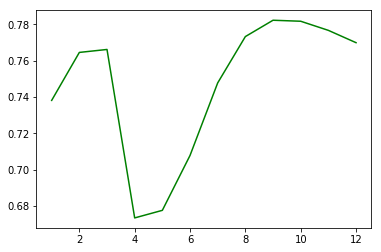

In [11]:
plt.plot(degree,  loss, color='green')

plt.plot()
plt.show()
plt.close()

## Task c) Validate and Visualize Radial Basis Regression

In [17]:
#radial regression
Y = np.array(Yi)
x = np.array(Xi)
padding = np.ones(len(x))
X = np.stack((padding, x), axis=1)
trainX = X
testX = X
trainY = Y
testY =Y
b, loss, Yp = ridge_regress(trainX, trainY, testX, testY, delta=10, mode='radial', lmbda=1)
loss

0.1658498711107676

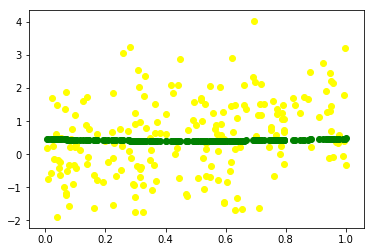

In [18]:
plt.scatter(x,  Y, color='yellow')
plt.scatter(x, Yp.tolist(), color='green')
plt.plot()
plt.show()
plt.close()